In [97]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize, visualize_same_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import main
from mambapy.mamba_lm import MambaLM, MambaLMConfig
from mambapy.mamba import Mamba, MambaConfig, RMSNorm
import ast
import DSA
import copy
from notebooks.utils_mamba import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load config

In [98]:
config = load_config("../config.yaml")
taskset = "PDM"

### Get dynamics to plot

In [99]:
model = "mamba_16_1_0.01_32_train.pth"

#### Pretrain unfrozen

In [100]:
group = "master"
device = "cpu"
d_model, n_layers, learning_rate, batch_size = parse_model_info(model)
curve_master = get_dynamics_mamba(
    d_model,
    n_layers,
    learning_rate,
    batch_size,
    model,
    group,
    taskset,
    device,
)

In [101]:
group = "pretrain_frozen"
device = "cpu"
d_model, n_layers, learning_rate, batch_size = parse_model_info(model)
curve_pretrain_frozen = get_dynamics_mamba(
    d_model,
    n_layers,
    learning_rate,
    batch_size,
    model,
    group,
    taskset,
    device,
)

In [102]:
group = "pretrain_basic_frozen"
device = "cpu"
d_model, n_layers, learning_rate, batch_size = parse_model_info(model)
curve_pretrain_basic_frozen = get_dynamics_mamba(
    d_model,
    n_layers,
    learning_rate,
    batch_size,
    model,
    group,
    taskset,
    device,
)

In [103]:
group = "untrained"
device = "cpu"
d_model, n_layers, learning_rate, batch_size = parse_model_info(model)
curve_untrained = get_dynamics_mamba(
    d_model,
    n_layers,
    learning_rate,
    batch_size,
    model,
    group,
    taskset,
    device,
)

In [104]:
curves = [curve_master, curve_pretrain_frozen, curve_pretrain_basic_frozen, curve_untrained]
curves_reduced_to_plot, explained_variance = main.compute_common_pca(curves, n_components=3)

In [105]:
explained_variance

0.5109979248707621

In [106]:
curve_master.shape

torch.Size([200, 200, 512])

#### Visualize the curves

In [107]:
# average each curve over second dimension
# curves_averaged = [curve[:,0,:] for curve in curves_reduced_to_plot]
curves_averaged = [np.mean(curve, axis=1) for curve in curves_reduced_to_plot]

/Users/qguilhot/Library/Mobile Documents/com~apple~CloudDocs/ETHZ/RepAL/dsa_analysis/visualize_patterns.py:90: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


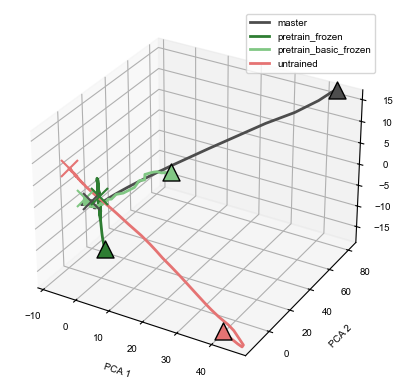

In [108]:
visualize_same_plot(curves_averaged, ["master", "pretrain_frozen", "pretrain_basic_frozen", "untrained"], palette = color_mapping)

In [109]:
dissimilarities = np.zeros((len(curves), len(curves)))
for i in range(len(curves)):
    for j in range(i, len(curves)):
        # compute DSA dissimilarity matrix
        # compute common pca between two curves
        curves_reduced, explained_variance = main.compute_common_pca(
            [curves[i], curves[j]], n_components=5
        )
        print(f"Explained variance between {i} and {j}: {explained_variance}")
        dsa_comp = DSA.DSA(
            curves_reduced[0],
            curves_reduced[1],
            # n_delays=config["dsa"]["n_delays"],
            n_delays=17,
            rank=100,
            # delay_interval=config["dsa"]["delay_interval"],
            delay_interval=11,
            verbose=True,
            iters=1000,
            lr=1e-2,
            device="cpu",
        )
        dis = dsa_comp.fit_score()
        dissimilarities[i, j] = dis

Explained variance between 0 and 0: 0.9438880623659135
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 0 and 0
Finished optimizing C
Finished optimizing C
Explained variance between 0 and 1: 0.8335253208027311
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 0 and 0
Finished optimizing C
Finished optimizing C
Explained variance between

In [110]:
for i in range(len(curves)):
    for j in range(i):
        dissimilarities[i, j] = dissimilarities[j, i]

<Axes: >

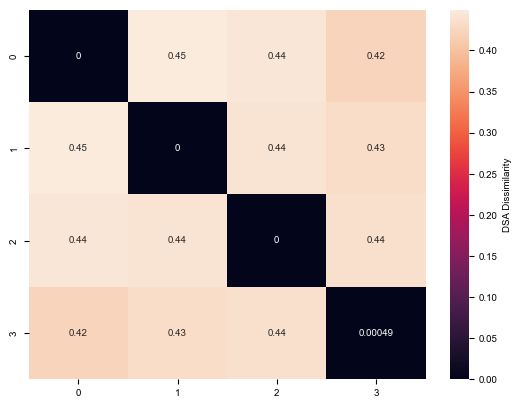

In [111]:
sns.heatmap(dissimilarities, annot=True, cbar_kws={"label": "DSA Dissimilarity"})

In [112]:
curve_1 = curves[0]
curve_1.shape

torch.Size([200, 200, 512])

In [113]:
curve_1_reduce = curve_1.mean(axis=1)
curve_1_reduce.shape

torch.Size([200, 512])

In [114]:
dissimilarities = np.zeros((len(curves), len(curves)))
for i in range(len(curves)):
    for j in range(i, len(curves)):
        # compute DSA dissimilarity matrix
        # compute common pca between two curves
        curves_reduced, explained_variance = main.compute_common_pca(
            [curves[i], curves[j]], n_components=5
        )
        curves_reduced_mean =[curve.mean(axis=1) for curve in curves_reduced]
        print(f"Explained variance between {i} and {j}: {explained_variance}")
        print(curves_reduced_mean[0].shape)
        dsa_comp = DSA.DSA(
            curves_reduced_mean[0],
            curves_reduced_mean[1],
            # n_delays=config["dsa"]["n_delays"],
            n_delays=33,
            rank=100,
            # delay_interval=config["dsa"]["delay_interval"],
            delay_interval=3,
            verbose=True,
            iters=1000,
            lr=1e-2,
            device="cpu",
        )
        dis = dsa_comp.fit_score()
        dissimilarities[i, j] = dis

Explained variance between 0 and 0: 0.9438888230012393
(200, 5)
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 0 and 0
Finished optimizing C
Finished optimizing C
Explained variance between 0 and 1: 0.8336077027988336
(200, 5)
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 0 and 0
Finished optimizing C
Finished optimizing C
Explaine

<Axes: >

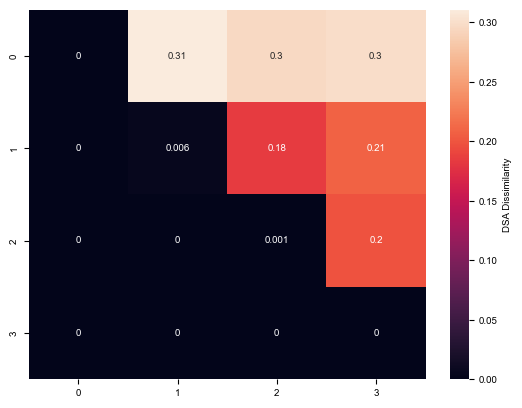

In [115]:
sns.heatmap(dissimilarities, annot=True, cbar_kws={"label": "DSA Dissimilarity"})